In [26]:
import os, sys, glob
import warnings
warnings.filterwarnings("ignore")

import argparse
parser = argparse.ArgumentParser()
# Dataset
parser.add_argument('--set', type=str, default='valid')
# Model/Config
parser.add_argument('--step', type=str, default='050000')
parser.add_argument('--ckpt_selector', type=str, default='ema')
parser.add_argument('--cfg_name', type=str, default=None)
parser.add_argument('--log_dir', type=str, default=None)
# Interpolation
parser.add_argument('--interpolate', nargs='+', default=None)
parser.add_argument('--interpolate_step', type=int, default=15)
parser.add_argument('--interpolate_noise', action='store_true', default=False)
parser.add_argument('--lerp', action='store_true', default=False)
parser.add_argument('--slerp', action='store_true', default=False)
parser.add_argument('--uncond_sampling', action='store_true', default=False)
parser.add_argument('--uncond_sampling_iters', type=int, default=1)
parser.add_argument('--reverse_sampling', action='store_true', default=False)
parser.add_argument('--separate_reverse_sampling', action='store_true', default=False)
# Samples selection
parser.add_argument('--n_subject', type=int, default=-1)
parser.add_argument('--sample_pair_json', type=str, default=None)
parser.add_argument('--sample_pair_mode', type=str, default=None)
parser.add_argument('--src_dst', nargs='+', default=[])
# Pertubation the image condition
parser.add_argument('--perturb_img_cond', action='store_true', default=False)
parser.add_argument('--perturb_mode', type=str, default='zero')
parser.add_argument('--perturb_where', nargs='+', default=[])

# Rendering
parser.add_argument('--render_mode', type=str, default="shape")
parser.add_argument('--rotate_normals', action='store_true', default=False)
# Diffusion
parser.add_argument('--diffusion_steps', type=int, default=1000)
parser.add_argument('--denoised_clamp', type=float, default=None)
# Misc
parser.add_argument('--seed', type=int, default=23)
parser.add_argument('--gpu_id', type=str, default="0")
parser.add_argument('--save_intermediate', action='store_true', default=False)
parser.add_argument('--postfix', type=str, default='')
parser.add_argument('--ovr_img', type=str, default=None)
parser.add_argument('--ovr_mod', action='store_true', default=False)
parser.add_argument('--norm_img', action='store_true', default=False)
parser.add_argument('--use_global_norm', action='store_true', default=False)
parser.add_argument('--norm_space', type=str, default='rgb')

args = parser.parse_args(args=[])

import os, sys, glob
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL, cv2
import json
import copy
import time
import torchvision
import pytorch_lightning as pl
import scipy
sys.path.insert(0, '../../')
from guided_diffusion.script_util import (
    seed_all,
)

from guided_diffusion.tensor_util import (
    make_deepcopyable,
    dict_slice,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, figsize=(8, 6)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

# Sample utils
sys.path.insert(0, '../')
from sample_utils import (
    ckpt_utils, 
    params_utils, 
    vis_utils, 
    file_utils, 
    inference_utils, 
    mani_utils,
)
device = 'cuda' if th.cuda.is_available() and th._C._cuda_getDeviceCount() > 0 else 'cpu'

In [27]:
seed_all(47)

################ SETTINGS ################
args.cfg_name = "Masked_Face_woclip+BgNoHead+shadow_256.yaml"
args.log_dir = "Masked_Face_woclip+BgNoHead+shadow_256"

# args.step = '050000'
args.step = '085000'
args.ckpt_selector = 'ema'
args.set = 'valid'
# args.sample_pair_json = './sample_json/itw_samples.json'
# args.sample_pair_json = './sample_json/ipynb_samples.json'
# args.sample_pair_json = './sample_json/debug_multipie.json'
args.sample_pair_json = '/home/mint/guided-diffusion/sample_scripts/paper_script/sample_json/teaser_ffhq.json'

args.sample_pair_mode = 'pair'


# Load Ckpt
if args.cfg_name is None:
    args.cfg_name = args.log_dir + '.yaml'
ckpt_loader = ckpt_utils.CkptLoader(log_dir=args.log_dir, cfg_name=args.cfg_name)
cfg = ckpt_loader.cfg

print(f"[#] Sampling with diffusion_steps = {args.diffusion_steps}")
cfg.diffusion.diffusion_steps = args.diffusion_steps
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=args.ckpt_selector, step=args.step)
model_dict = inference_utils.eval_mode(model_dict)

# Load dataset
dataset = 'ffhq'
cfg.dataset.training_data = 'ffhq_256_with_anno'
cfg.dataset.root_path = '/data/mint/DPM_Dataset/'
if dataset == 'itw':
    img_dataset_path = f"/data/mint/DPM_Dataset/ITW/itw_images_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ITW/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'ITW'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/itw_images_aligned/'
elif dataset == 'ffhq':
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
    img_ext = '.jpg'
    cfg.dataset.training_data = 'ffhq_256_with_anno'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
elif dataset == 'mp':
    img_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/mp_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'MultiPIE'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/mp_aligned/'
else: raise NotImplementedError

cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, avg_dict = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector,
    rmv_params=cfg.param_model.rmv_params,
    set_=args.set,
    cfg=cfg,
    mode='sampling',
    img_ext=img_ext,
)


[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml')

[#] Sampling with diffusion_steps = 1000
[#] Available ckpt :  ['_085000.pt', '_085000.pt']
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Use Hadamart-tanh
[#] Loading.../data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256//ImgCond_em

Loading deca params...: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead']
DPM Image condition :  [None]


In [28]:
data_size = dataset.__len__()
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{args.set}")

denoised_fn = None
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, 
                                            diffusion=diffusion, 
                                            reverse_fn=diffusion.ddim_reverse_sample_loop, 
                                            forward_fn=diffusion.ddim_sample_loop,
                                            denoised_fn=denoised_fn,
                                            cfg=cfg,
                                            args=args)

# DECA Estimate

In [29]:
sys.path.insert(1, '/home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

def deca_estimate(img_path):
    mask_dir = '/home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/data/'
    testdata = datasets.TestData(img_path, iscrop=True, face_detector='fan', sample_step=10)
    print(img_path)
    f_mask = np.load(f'{mask_dir}/FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
    v_mask = np.load(f'{mask_dir}/FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
    mask={
        'v_mask':v_mask['face'].tolist(),
        'f_mask':f_mask['face'].tolist()
    }
    deca_cfg.model.use_tex = False
    deca_cfg.rasterizer_type = 'standard'
    deca_cfg.model.extract_tex = False
    deca = DECA(config = deca_cfg, device=device, mode='deca', mask=mask)
    
    name = testdata[0]['imagename']
    ext = testdata[0]['imageext']
    images = testdata[0]['image'].to(device)[None,...]
    original_image = testdata[0]['original_image'][None, ...].to(device)
    tform = testdata[0]['tform'][None, ...]
    print(th.mean(tform))
    print(th.mean(original_image))
    print(tform)
    print(original_image.shape)
    
    with th.no_grad():
        codedict = deca.encode(images)
        tform_inv = th.inverse(tform).transpose(1,2).to(device)
        print(tform_inv)
        _, orig_visdict = deca.decode(codedict, render_orig=True, original_image=original_image, tform=tform_inv, use_template=False, mean_cam=None)    
        orig_visdict['inputs'] = original_image
        
    del deca
    
    return codedict, orig_visdict
    

/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/valid/67400.jpg
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
tensor(-12.27778)
tensor(0.36721, device='cuda:0')
tensor([[[ 1.16146e+00,  1.93422e-16, -3.19401e+01],
         [ 6.44739e-17,  1.16146e+00, -8.18828e+01],
         [ 0.00000e+00,  0.00000e+00,  1.00000e+00]]])
torch.Size([1, 3, 256, 256])
tensor([[[ 8.60987e-01, -4.77944e-17,  0.00000e+00],
         [-1.43383e-16,  8.60987e-01,  0.00000e+00],
         [ 2.75000e+01,  7.05000e+01,  1.00000e+00]]], device='cuda:0')
/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/valid/66646.jpg
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
tensor(-8.38755)
tensor(0.40234, device='cuda:0')
tensor([[[ 1.07729e

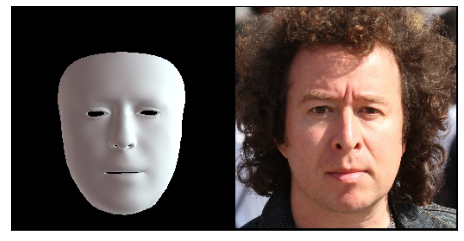

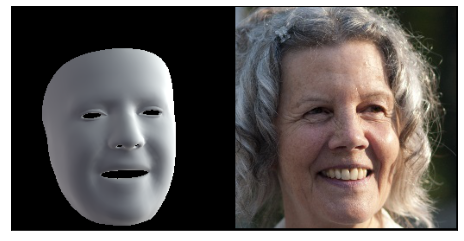

In [30]:
# src_img_name = "046_01_01_051_07"
# dst_img_name = "046_01_01_051_13"
src_img_name = "67400"
dst_img_name = "66646"

# src_img_name = "044_01_01_051_04"
# dst_img_name = "044_01_01_051_13"
# src_img_name = "002_01_01_051_06"
# dst_img_name = "002_01_01_051_01"

# src_img_name = "001_01_01_051_06"
# dst_img_name = "001_01_01_051_08"

# Rendered
# src_img_path = f'/data/mint/DPM_Dataset/MultiPIE/mp_aligned/valid/{src_img_name}.png'
src_img_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/valid/{src_img_name}.jpg'
src_deca_p, visdict = deca_estimate(img_path=src_img_path)
vis_img = th.cat((th.clip(visdict['shape_images'], 0, 1), visdict['inputs']))
show(torchvision.utils.make_grid(vis_img))

# dst_img_path = f'/data/mint/DPM_Dataset/MultiPIE/mp_aligned/valid/{dst_img_name}.png'
dst_img_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/valid/{dst_img_name}.jpg'
dst_deca_p, visdict = deca_estimate(img_path=dst_img_path)
vis_img = th.cat((th.clip(visdict['shape_images'], 0, 1), visdict['inputs']))
show(torchvision.utils.make_grid(vis_img))

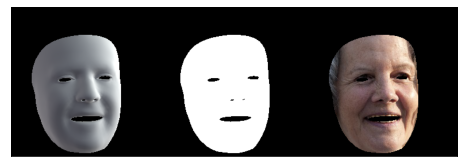

In [31]:
vis_img = th.cat((th.clip(visdict['shape_images'], 0, 1), visdict['shape_images'] != 0, ((visdict['shape_images'] != 0) * visdict['inputs'])))
show(torchvision.utils.make_grid(vis_img))

In [32]:
print(th.mean(src_deca_p['shape']))
print(th.mean(src_deca_p['pose']))
print(th.mean(src_deca_p['exp']))
print(th.mean(src_deca_p['cam']))
print(th.mean(src_deca_p['light']))
print(th.mean(src_deca_p['images']))

tensor(-0.02720, device='cuda:0')
tensor(0.04517, device='cuda:0')
tensor(-0.03844, device='cuda:0')
tensor(3.35045, device='cuda:0')
tensor(0.57968, device='cuda:0')
tensor(0.39475, device='cuda:0')


# Arcface Estimate

In [33]:
sys.path.insert(2, '/home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/Arcface/')
from get_arcface_emb import get_arcface_emb

_ , src_faceemb = get_arcface_emb(img_path=src_img_path, device='cuda', arcface_ckpt_path='../cond_utils/arcface/pretrained/BEST_checkpoint_r18.tar')
src_faceemb = src_faceemb

Open&Resize images: 1it [00:00, 633.01it/s]
Generate Face Embedding: 1it [00:00,  3.04it/s]


# Create Non-spatial

In [34]:
# Create nonspatial condition
cond = {'cond_params':[], 'cond_img':[]}
n_step = 2
# repeats
for p in cfg.param_model.params_selector:
    if p == 'faceemb':
        cond[p] = np.repeat(src_faceemb, repeats=n_step, axis=0)
    elif p == 'shadow':
        cond[p] = np.zeros((n_step, 1)) + (-1.6358844929000687)
    else:
        cond[p] = np.repeat(src_deca_p[p].cpu().numpy(), repeats=n_step, axis=0)
    cond[p] = th.tensor(cond[p]).to(device)
        
# concat
for p in cfg.param_model.params_selector:
    cond['cond_params'].append(cond[p])
cond['cond_params'] = th.cat((cond['cond_params']), dim=-1)



# Create Spatial

In [35]:
# Create non-spatial condition
cond['light'] = src_deca_p['light']
cond['light'] = mani_utils.interp_cond(src_cond=src_deca_p['light'],
                                       dst_cond=dst_deca_p['light'], 
                                       n_step=n_step, 
                                       interp_fn=mani_utils.lerp
                                    )
cond['light'] = th.tensor(cond['light']).to(device)

def deca_render(img_path, cond, B):
    mask_dir = '/home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/data/'
    testdata = datasets.TestData(img_path, iscrop=True, face_detector='fan', sample_step=10)
    
    original_image = testdata[0]['original_image'][None].to(device).float().repeat(B, 1, 1, 1) / 255.0
    # original_image = testdata[0]['original_image'][None].repeat(B, 1, 1, 1).to(device) / 255.0
    tform = testdata[0]['tform'].repeat(B, 1).to(device)[None].reshape(-1, 3, 3)
    tform_inv = th.inverse(tform).transpose(1,2)
    print(tform)
    print(tform_inv)
    cond['images'] = testdata[0]['image'].to(device)[None].float().repeat(B, 1, 1, 1)
    
    f_mask = np.load(f'{mask_dir}/FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
    v_mask = np.load(f'{mask_dir}/FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
    mask={
        'v_mask':v_mask['face'].tolist(),
        'f_mask':f_mask['face'].tolist()
    }
    deca_cfg.model.use_tex = False
    deca_cfg.rasterizer_type = 'standard'
    deca_cfg.model.extract_tex = False
    
    images = testdata[0]['image'].to(device)[None,...]
    deca = DECA(config = deca_cfg, device=device, mode='deca', mask=mask)
    
    start = time.time()
    _, orig_visdict = deca.decode(cond, 
                                render_orig=True, 
                                original_image=original_image, 
                                tform=tform_inv.to(device), 
                                use_template=False, 
                                mean_cam=None, 
                                use_detail=False,
                                rotate_normals=False,
                            )  
    rendered_image = orig_visdict['shape_images']
    print("Rendering time : ", time.time() - start)
    return rendered_image


[#] Interpolate with <function lerp at 0x7f2235272550>


tensor([[[ 1.16146e+00,  1.93422e-16, -3.19401e+01],
         [ 6.44739e-17,  1.16146e+00, -8.18828e+01],
         [ 0.00000e+00,  0.00000e+00,  1.00000e+00]],

        [[ 1.16146e+00,  1.93422e-16, -3.19401e+01],
         [ 6.44739e-17,  1.16146e+00, -8.18828e+01],
         [ 0.00000e+00,  0.00000e+00,  1.00000e+00]]], device='cuda:0')
tensor([[[ 8.60987e-01, -4.77944e-17,  0.00000e+00],
         [-1.43383e-16,  8.60987e-01,  0.00000e+00],
         [ 2.75000e+01,  7.05000e+01,  1.00000e+00]],

        [[ 8.60987e-01, -4.77944e-17,  0.00000e+00],
         [-1.43383e-16,  8.60987e-01,  0.00000e+00],
         [ 2.75000e+01,  7.05000e+01,  1.00000e+00]]], device='cuda:0')
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/preprocess_scripts/Relighting_preprocessing_tools/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
Rendering time :  0.024324893951416016


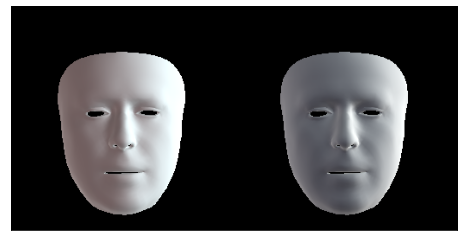

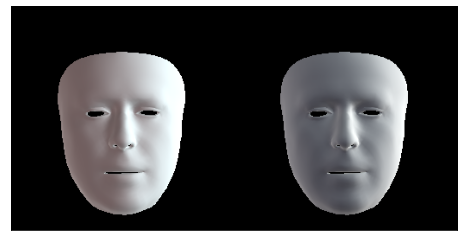

In [36]:
render_face = deca_render(src_img_path, cond, B=n_step)
show(torchvision.utils.make_grid(th.clip(render_face, 0, 1)))
img_size = cfg.img_model.image_size
tmp = []
for j in range(render_face.shape[0]):
    r_tmp = render_face[j].cpu().numpy().transpose((1, 2, 0))
    r_tmp = cv2.resize(r_tmp, (img_size, img_size), cv2.INTER_AREA)
    r_tmp = np.transpose(r_tmp, (2, 0, 1))
    tmp.append(r_tmp)
render_face = np.stack(tmp, axis=0)
render_face = th.tensor(render_face)
show(torchvision.utils.make_grid(th.clip(render_face, 0, 1)))
cond['deca_masked_face_images_woclip'] = render_face

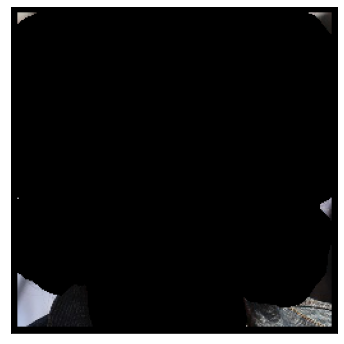

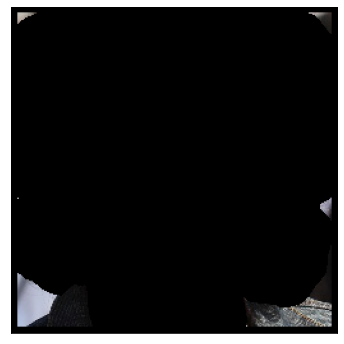

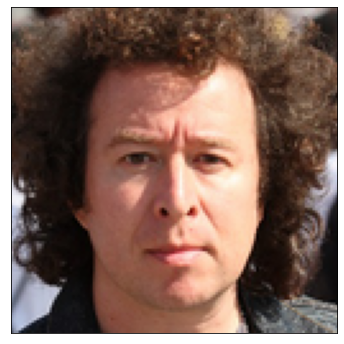

In [37]:
def face_segment(segment_part, img_path, dilate=None):
    from scipy import ndimage
    face_segment_anno = PIL.Image.open(img_path)

    face_segment_anno = np.array(face_segment_anno)
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))
    
    if segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
     
    if dilate is not None:   
        seg_m = ndimage.binary_erosion(seg_m, iterations=dilate)
    return seg_m


img_size = cfg.img_model.image_size
# Load image.
src_img = PIL.Image.open(src_img_path)#.resize((128, 128), PIL.Image.ANTIALIAS)
src_img = np.array(src_img)

# bg_img_path = f'/data/mint/DPM_Dataset/MultiPIE/face_segment/valid/anno/anno_{src_img_name}.png'
bg_img_path = f'/data/mint/DPM_Dataset/ffhq_256_with_anno/face_segment/valid/anno/anno_{src_img_name}.png'
mask = face_segment('faceseg_nohead', bg_img_path, dilate=5)[..., None]

bg = src_img * mask
show(torchvision.utils.make_grid(th.tensor(bg).permute(2, 0, 1)[None]))

bg = PIL.Image.fromarray(bg.astype(np.uint8)).resize((img_size, img_size), PIL.Image.ANTIALIAS)

bg = np.transpose(bg, [2, 0, 1])
bg = (bg / 127.5) - 1
bg = th.tensor(bg)
cond['faceseg_nohead'] = bg[None]
show(torchvision.utils.make_grid((bg + 1) * 0.5))


src_img = PIL.Image.open(src_img_path).resize((128, 128), PIL.Image.ANTIALIAS)
src_img = th.tensor(np.array(src_img)).permute(2, 0, 1)
src_img = (src_img / 127.5) - 1
cond['src_img'] = src_img[None]
show(torchvision.utils.make_grid((src_img + 1) * 0.5))



cond_params torch.Size([2, 672])
cond_img 0
shape torch.Size([2, 100])
pose torch.Size([2, 6])
exp torch.Size([2, 50])
cam torch.Size([2, 3])
faceemb torch.Size([2, 512])
shadow torch.Size([2, 1])
light torch.Size([2, 9, 3])
images torch.Size([2, 3, 224, 224])
deca_masked_face_images_woclip torch.Size([2, 3, 256, 256])
faceseg_nohead torch.Size([1, 3, 256, 256])
src_img torch.Size([1, 3, 128, 128])


RuntimeError: Sizes of tensors must match except in dimension 1. Got 2 and 3 in dimension 0 (The offending index is 1)

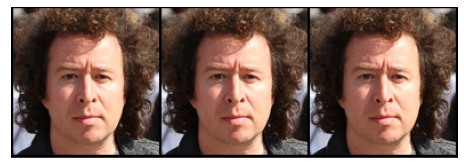

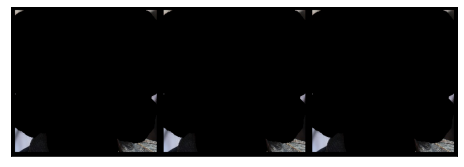

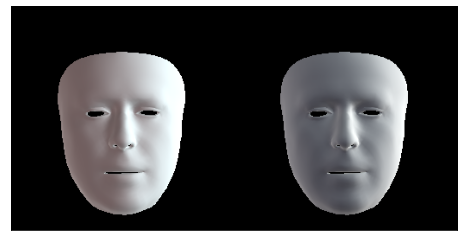

In [38]:
cond_f = copy.deepcopy(cond)
for k in cond.keys():
    if isinstance(cond_f[k], list):
        print(k, len(cond_f[k]))
    else:
        print(k, cond_f[k].shape)
        
cond_f['src_img'] = th.repeat_interleave(cond_f['src_img'], repeats=3, dim=0)
cond_f['faceseg_nohead'] = th.repeat_interleave(cond_f['faceseg_nohead'], repeats=3, dim=0)

show(torchvision.utils.make_grid((cond_f['src_img'] + 1) * 0.5))
show(torchvision.utils.make_grid((cond_f['faceseg_nohead'] + 1) * 0.5))
show(torchvision.utils.make_grid((th.clip(cond_f['deca_masked_face_images_woclip'], 0, 1))))

tmp = []
for p in cfg.img_cond_model.in_image:
    tmp.append(cond_f[p])

cond_f['cond_img'] = th.cat(tmp, axis=1)
print(cond_f['cond_img'].shape)
show(torchvision.utils.make_grid((cond_f['cond_img'][:, 0:3])))
show(torchvision.utils.make_grid((cond_f['cond_img'][:, 3:] + 1) * 0.5))


# Relighting

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

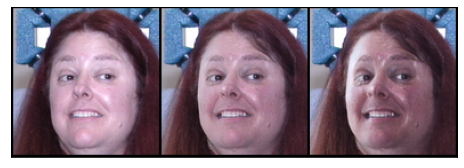

In [12]:
# Reverse 
diffusion.num_timesteps = 1000
cond_f['use_cond_xt_fn'] = False
cond_f['dpm_cond_img'] = None
cond_f['use_render_itp'] = False

cond_rev = copy.deepcopy(cond_f)
cond_rev = dict_slice(in_d=cond_rev, keys=['cond_params', 'cond_img'], n=1) # Slice only 1st image out for inversion
if cfg.img_cond_model.apply:
    cond_rev = pl_sampling.forward_cond_network(model_kwargs=cond_rev)
    
reverse_ddim_sample = pl_sampling.reverse_proc(x=cond_f['src_img'][0:1, ...], 
                                               model_kwargs=cond_rev, 
                                               store_mean=True)
noise_map = reverse_ddim_sample['final_output']['sample']
rev_mean = reverse_ddim_sample['intermediate']

#NOTE: rev_mean WILL BE MODIFIED; This is for computing the ratio of inversion (brightness correction).
sample_ddim = pl_sampling.forward_proc(
    noise=noise_map,
    model_kwargs=cond_rev,
    store_intermediate=False,
    rev_mean=rev_mean)

# Relight!
cond_f['use_render_itp'] = True
cond_relight = copy.deepcopy(cond_f)
if cfg.img_cond_model.apply:
    cond_relight = pl_sampling.forward_cond_network(model_kwargs=cond_relight)
    
assert noise_map.shape[0] == 1
rev_mean_first = [x[:1] for x in rev_mean]

relight_out = pl_sampling.forward_proc(
    noise=th.repeat_interleave(noise_map, repeats=n_step, dim=0),
    model_kwargs=cond_relight,
    store_intermediate=False,
    add_mean=rev_mean_first)
    
out = relight_out["final_output"]["sample"]
show(torchvision.utils.make_grid((out + 1) * 0.5))

tensor(6.38126e-05, device='cuda:0', dtype=torch.float64)
tensor(0.02202, device='cuda:0', dtype=torch.float64)
tensor(0.30045, dtype=torch.float64)
tensor(0.84404, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(-0.79204, dtype=torch.float64)
tensor(3.31479, device='cuda:0')


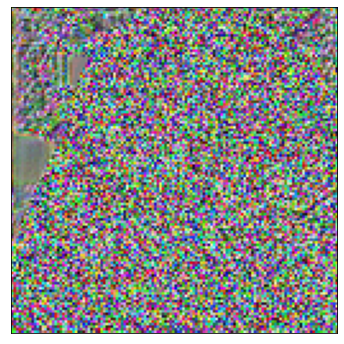

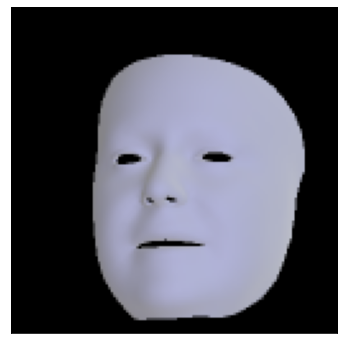

In [26]:
show(torchvision.utils.make_grid((noise_map + 1) * 0.5))
print(th.mean(noise_map))
print(th.mean(cond_f['cond_params']))
print(th.mean(cond_f['cond_img'][0, 0:3]))
show(torchvision.utils.make_grid((cond_f['cond_img'][0, 0:3])))
print(th.max(cond_f['cond_img'][0, 0:3]))
print(th.min(cond_f['cond_img'][0, 0:3]))
print(th.mean(cond_f['cond_img'][0, 3:6]))
print(th.mean(cond_f['cam']))